In [1]:
from abc import ABC, abstractmethod
import numpy as np 
from util import *
import gym
import os
%load_ext autoreload
%autoreload 2

L_SOFTPLUS = 0
L_RELU = 1
L_LINEAR = 2
L_SIGMOID = 3
L_DISCRETE = 4
LS_REAL = [L_SOFTPLUS, L_RELU, L_LINEAR, L_SIGMOID]

def softplus_i(x):
  r = np.full(x.shape, 1, x.dtype)
  r[x>30] = x[x>30]
  r[np.abs(x)<=30] = np.log1p(np.exp(x[np.abs(x)<=30]))
  return x/r

def softmax_i(x):
  return x/softmax(x)

def sigmoid_d(x):
  s = sigmoid(x)
  return s * (1-s)

def sigmoid_i(x):
  return x/sigmoid(X)

ACT_F = {L_SOFTPLUS: softplus,
         L_RELU: relu,
         L_SIGMOID: sigmoid,
         L_LINEAR: lambda x: x,
         }

ACT_D_F = {L_SOFTPLUS: sigmoid,
           L_RELU: relu_d,
           L_SIGMOID: sigmoid_d,
           L_LINEAR: lambda x: 1,
           }

ACT_I_F = {L_SOFTPLUS: softplus_i,
           L_LINEAR: lambda x: 1,
           L_SIGMOID: sigmoid_i,
           L_DISCRETE: softmax_i,           
          }

class eq_prop_layer():
  def __init__(self, name, input_size, output_size, optimizer, var, var_learnable, temp, l_type,
               mv_adj=False, mv_alpha=1e3, mv_beta=0.8, mv_epsilon=1e-6, explore_p=1):
    if l_type not in [L_SOFTPLUS, L_RELU, L_LINEAR, L_SIGMOID, L_DISCRETE]:
      raise Exception('l_type (%d) not implemented' % l_type)
    
    self.name = name
    self.input_size = input_size
    self.output_size = output_size
    self.optimizer = optimizer
    self.l_type = l_type
    self.var_learnable = var_learnable
    self.temp = temp if l_type == L_DISCRETE else 1
    
    lim = np.sqrt(6 / (input_size + output_size))       
    self._w = np.random.uniform(-lim, lim, size=(input_size, output_size))
    self._b = np.zeros(shape=output_size)    
    self._inv_var = np.full(output_size, 1/var) if var > 0 else None
    
    self.prev_layer = None # Set manually
    self.next_layer = None # Set manually
    self.values = np.zeros((1, output_size))
    self.new_values = np.zeros((1, output_size))
    
    self.mv_adj = mv_adj
    if self.mv_adj:      
      self.mv_alpha = mv_alpha
      self.mv_beta = mv_beta
      self.mv_epsilon = mv_epsilon
      self.mv = np.full((1, output_size), 1/self.mv_alpha)
    
    self.w_trace = np.zeros((1, input_size, output_size,))
    self.b_trace = np.zeros((1, output_size,))
    
    if var > 0: self.inv_var_trace = np.zeros((1, output_size,))
    
    self.explore_p = explore_p
    
  def sample(self, inputs):    
    self.compute_pot_mean(inputs)          
    if self.l_type in LS_REAL:
      if self._inv_var is None:
        self.values = self.mean
      else:
        sigma = np.sqrt(1/self._inv_var)
        self.values = self.mean + sigma * np.random.normal(size=self.pot.shape)
        if self.explore_p < 1:           
          self.explore_b = (np.random.rand(self.inputs.shape[0], self._b.shape[0]) < self.explore_p)
          self.values[~self.explore_b] = self.mean[~self.explore_b]        
      return self.values
    elif self.l_type == L_DISCRETE:      
      self.values = multinomial_rvs(n=1, p=self.mean)
      if self.explore_p < 1:        
        d = np.zeros_like(self.values)        
        d[np.where(self.mean==np.max(self.mean,axis=-1)[:,np.newaxis])] = 1        
        self.explore_b = (np.random.rand(self.inputs.shape[0]) < self.explore_p)
        self.explore_b  = np.broadcast_to(self.explore_b[:, np.newaxis], self.explore_b.shape + (self._w.shape[1],))
        self.values[~self.explore_b] = d[~self.explore_b]
      return self.values
  
  def compute_pot_mean(self, inputs):
    # Compute potential (pre-activated mean value) and mean value of layer
    self.inputs = inputs    
    self.pot = (inputs.dot(self._w) + self._b)
    if self.l_type in LS_REAL:        
      self.mean = ACT_F[self.l_type](self.pot)
    else:       
      self.mean = softmax(self.pot/self.temp, axis=-1)
  
  def refresh(self, freeze_value):    
    if self.prev_layer is not None: self.inputs = self.prev_layer.new_values                
    self.compute_pot_mean(self.inputs)   
    if self.mv_adj:
      if self.l_type in LS_REAL:
        self.mv = self.mv_beta * self.mv + (1-self.mv_beta) * (self.new_values-self.values)
      else:
        self.mv = self.mv_beta * self.mv + (1-self.mv_beta) * np.sum((self.new_values!=self.values).astype(np.float), axis=-1)
    if not freeze_value: self.values = self.new_values    
  
  def update(self, update_size, update_noise, map_clip):
    # MAP est. gradient ascent, assuming all layers are refreshed 
    if self.next_layer is None: 
      if self.l_type in LS_REAL:
        sigma = np.sqrt(1/self._inv_var)
        self.new_values = self.mean + sigma * np.random.normal(size=self.pot.shape)      
      elif self.l_type == L_DISCRETE:      
        self.new_values = multinomial_rvs(n=1, p=self.mean)
      #self.new_values = self.mean
    elif self.l_type in LS_REAL:
      lower_pot = (self.mean - self.values) * self._inv_var
      if self.next_layer is None:
        upper_pot = 0.
      else:
        fb_w = self.next_layer._w.T          
        if self.next_layer.l_type in LS_REAL:
          upper_pot = ((self.next_layer.values - self.next_layer.mean) *
                      ACT_D_F[self.next_layer.l_type](self.next_layer.pot) * self.next_layer._inv_var).dot(fb_w)      
        else:
          upper_pot = (self.next_layer.values - self.next_layer.mean).dot(fb_w)/self.next_layer.temp           
        
      update_pot = lower_pot + upper_pot        
      update_step = update_size * (update_pot + update_noise * np.random.normal(size=self.values.shape))        
      if map_clip is not None: update_step = np.clip(update_step, -map_clip, +map_clip)        
      self.new_values = self.values + update_step    

  def record_trace(self, gate=None, lambda_=0):
    if self.l_type in LS_REAL:
      v_ch = (self.values - self.mean) * ACT_D_F[self.l_type](self.pot) * self._inv_var
      #v_ch = (self.values - self.mean) * ACT_D_F[self.l_type](self.values) * self._inv_var
    else:
      v_ch = (self.values - self.mean) / self.temp
    if gate is not None:       
      v_ch *= gate[:, np.newaxis]
    if self.mv_adj:
      v_ch = v_ch * (1 / (self.mv_epsilon+self.mv_alpha*np.square(self.mv)))
    
    if self.explore_p < 1: v_ch[~self.explore_b] = 0.
      
    self.w_trace *= lambda_
    self.b_trace *= lambda_            
    self.w_trace = self.w_trace + self.inputs[:, :, np.newaxis] * v_ch[:, np.newaxis, :] 
    self.b_trace = self.b_trace + v_ch
    
    if self.l_type in LS_REAL and self.var_learnable:
      v_ch = 0.5*(1/self._inv_var - np.square(self.values-self.mean))
      if gate is not None: v_ch *= gate[:, np.newaxis]
      self.inv_var_trace = self.inv_var_trace * lambda_ + v_ch       
      
  def learn_trace(self, reward, lr=0.01, l2_reg=0, entro_reg=0):        
    w_update = self.w_trace * reward[:, np.newaxis, np.newaxis]   
    b_update = self.b_trace * reward[:, np.newaxis]

    if entro_reg != 0 and self.l_type == L_DISCRETE:
      enp = ((np.log(self.mean) + 1)*self.mean)[:,:,np.newaxis]*self.mean[:,np.newaxis,:]
      enp -= np.identity(self.output_size)
      enp = np.sum(enp, axis=-1)
      w_update -= entro_reg * enp[:, np.newaxis, :] * self.inputs[:, :, np.newaxis]            
      b_update -= entro_reg * enp

    w_update = np.average(w_update, axis=0) - l2_reg * self._w        
    b_update = np.average(b_update, axis=0) - l2_reg * self._b   
    
    delta_w = self.optimizer.delta(grads=[w_update], name=self.name+"_w", learning_rate=lr)[0]    
    delta_b = self.optimizer.delta(grads=[b_update], name=self.name+"_b", learning_rate=lr)[0]    
    self._w += delta_w    
    self._b += delta_b
      
    if self.l_type in LS_REAL and self.var_learnable:      
      inv_var_der_update = self.inv_var_trace * reward[:, np.newaxis] - 0.5 * entro_reg * (1/self._inv_var)
      inv_var_der_update = np.average(inv_var_der_update, axis=0)      
      delta_inv_var = self.optimizer.delta(grads=[inv_var_der_update], name=self.name+"_inv_var", learning_rate=lr)[0]      
      self._inv_var += delta_inv_var
      self._inv_var = np.maximum(self._inv_var, 0.1)
      
  def clear_trace(self, mask):    
    self.w_trace = self.w_trace * (mask.astype(np.float))[:, np.newaxis, np.newaxis]
    self.b_trace = self.b_trace * (mask.astype(np.float))[:, np.newaxis]
    if self._inv_var is not None:
      self.inv_var_trace = self.inv_var_trace * (mask.astype(np.float))[:, np.newaxis]
 
  def clear_values(self, mask):    
    self.values = self.values * (mask.astype(self.values.dtype))[:, np.newaxis]
    self.new_values = self.new_values * (mask.astype(self.new_values.dtype))[:, np.newaxis]
    if self.mv_adj: self.mv[mask==0] = 1/self.mv_alpha
      
  def backprop(self, grad, lr=0.01, l2_reg=0, lambda_=0):   
    if self.l_type == L_DISCRETE:
      v_ch = grad 
    else:
      v_ch = grad * ACT_D_F[self.l_type](self.pot) 
    w_update = self.inputs[:, :, np.newaxis] * v_ch[:, np.newaxis, :]    
    b_update = v_ch        
    
    if lambda_ == 0:
      w_update = np.average(w_update, axis=0) - l2_reg * self._w
      delta_w = self.optimizer.delta(grads=[w_update], name=self.name+"_bp_w", learning_rate=lr)[0]
      self._w += delta_w
      b_update = np.average(b_update, axis=0) - l2_reg * self._b
      delta_b = self.optimizer.delta(grads=[b_update], name=self.name+"_bp_b", learning_rate=lr)[0]
      self._b += delta_b    
    else:
      self.w_trace = self.w_trace * lambda_ + w_update
      self.b_trace = self.b_trace * lambda_ + b_update
    return v_ch.dot(self._w.T)
    

class Network():
  def __init__(self, state_n, action_n, hidden, var, var_learnable, temp, 
               hidden_l_type, output_l_type, opt="adam", beta_1=0.9, beta_2=0.999,
               mv_adj=False, mv_alpha=1e3, mv_beta=0.8, mv_epsilon=1e-6, explore_p=1):
    
    self.layers = []    
    in_size = state_n
    
    if opt == "adam":
      optimizer = adam_optimizer(learning_rate=0.01, beta_1=beta_1, beta_2=beta_2)            
    else:
      optimizer = simple_grad_optimizer(learning_rate=0.01)        

    for d, n in enumerate(hidden + [action_n]):
      a = eq_prop_layer(name="layer_%d"%d, input_size=in_size, output_size=n, 
                        optimizer=optimizer, var=getl(var,d), var_learnable=var_learnable, temp=temp,
                        l_type=(output_l_type if d==len(hidden) else hidden_l_type),
                        mv_adj=getl(mv_adj,d), mv_alpha=getl(mv_alpha,d), 
                        mv_beta=getl(mv_beta,d), mv_epsilon=getl(mv_epsilon,d),
                        explore_p=getl(explore_p,d))
      if d > 0: 
        a.prev_layer = self.layers[-1]        
        self.layers[-1].next_layer = a 
      self.layers.append(a)                  
      in_size = n

  def forward(self, state):        
    self.state = state
    h = state   
    for n, a in enumerate(self.layers): h = a.sample(h)                    
    self.action = h                
    return self.action      
  
  def backprop(self, reward, targ, lr, l2_reg, lambda_=0):
    if reward is not None:
      grad = reward[..., np.newaxis] * (self.layers[-1].values - self.layers[-1].mean) / self.layers[-1].temp       
    elif targ is not None:
      grad = (targ - self.layers[-1].mean) / self.layers[-1].temp      
    elif lambda_ > 0:
      grad = np.array([[1.]])
    for n in range(len(self.layers)-1, -1, -1):
      grad = self.layers[n].backprop(grad, lr=getl(lr, n), l2_reg=getl(l2_reg, n), lambda_=lambda_)
  
  def map_grad_ascent(self, steps, state=None, gate=False, lambda_=0, 
                      update_size=0.01, map_clip=None, update_noise=0.1, 
                      last_update=False):
    # forward mode if state is not None
    if state is not None:      
      self.layers[0].inputs = state
      for n, a in enumerate(self.layers): 
        a.refresh(freeze_value = False)

    for i in range(steps):              
      for n, a in enumerate(self.layers[:-1] if state is None else self.layers):
        a.update(update_size=getl(update_size,n), update_noise=getl(update_noise,n), map_clip=getl(map_clip,n))              
      for n, a in enumerate(self.layers): 
        a.refresh(freeze_value = (n == (len(self.layers)-1) and state is None))         
      if not last_update or (last_update and i == steps-1 and state is None):
        gate_c = 1/(self.layers[-1].values - self.layers[-1].mean)[:,0] if gate else None
        for n, a in enumerate(self.layers): a.record_trace(gate=gate_c, lambda_=lambda_)
          
    if state is not None:
      #return self.layers[-1].sample(self.layers[-1].inputs)
      return self.layers[-1].values
          
  def learn(self, reward, lr=0.01, l2_reg=0, entro_reg=0):    
    for n, a in enumerate(self.layers):
      a.learn_trace(reward=reward, lr=getl(lr, n), l2_reg=getl(l2_reg, n), 
                    entro_reg=getl(entro_reg,n))
          
  def clear_trace(self, mask):
    for n, a in enumerate(self.layers): a.clear_trace(mask)
      
  def clear_values(self, mask):
    for n, a in enumerate(self.layers): a.clear_values(mask)      


## Multiplexer Experiments

In [4]:
name="MAP Prop"
addr_size=5 # address size of MDP
hidden=[64,32] # hidden layers unit as list
l_type=L_SOFTPLUS 
var=[0.3, 1, 1] # variance in hidden layer normal dist.
temp=1
batch_size=128
map_grad_ascent_steps=0 # update step size for H 
update_size=[0.15,0.5,0.5] # update step size for H 
update_noise=0 # update noise injected for each update in H
last_update=True # whether to only learn at last update step for H   
trace=False # whether to use trace in update
l2_reg=0 # l2 reg.
backprop=True # whether to use backprop instead (control exp.)
explore_p=1
opt="adam" # optimizer, "adam" or "simple"
lr=[0.04,0.00004,0.000004] # learning rate
exp_num=10
train_count=4000000

env=complex_multiplexer_MDP(addr_size=addr_size, action_size=1, zero=False, reward_zero=False)  

l_learn = True
l2_reg = 0

if not last_update and not trace:
  if type(lr) == list: 
    lr = [x / (steps+1) for x in lr]
  else:
    lr /= (steps+1)

print_every = 128*500     
reward_hist_full = []

for j in range(exp_num):          
  net = Network(state_n=env.x_size, action_n=2**env.action_size,  hidden=hidden, var=var, var_learnable=False, temp=temp, 
               hidden_l_type=l_type, output_l_type=L_DISCRETE, opt="adam", beta_1=0.9, beta_2=0.999,
               mv_adj=False, mv_alpha=1e3, mv_beta=0.8, mv_epsilon=1e-6, explore_p=explore_p)
  
  reward_hist = []
  print_count = print_every         
  for i in range(train_count//batch_size):  
    state = env.reset(batch_size)        
    action = net.forward(state)[..., np.newaxis][:,:,0]
    action = zero_to_neg(from_one_hot(action))[:,np.newaxis]        
    reward = env.act(action)[:,0]    
    reward_hist.append(np.average(reward))   
    
    if backprop:
      net.backprop(reward=reward, targ=None, lr=lr, l2_reg=l2_reg)
    else:
      if map_grad_ascent_steps > 0:
        net.map_grad_ascent(steps=map_grad_ascent_steps, state=None, gate=False, lambda_=0, 
                    update_size=update_size, map_clip=None, 
                    update_noise=update_noise, last_update=last_update)
      else:
        for n, a in enumerate(net.layers): a.record_trace(gate=None, lambda_=0)          
      net.learn(reward, lr=lr, l2_reg=l2_reg, entro_reg=0,)
      
    if i*batch_size > print_count:
      f_str = "Step %d (%d) Reward \t%f "
      f_arg = [i, i*batch_size, np.average(reward_hist[-print_every//batch_size:])]
      print(f_str % tuple(f_arg))
      print_count += print_every      
  reward_hist_full.append(reward_hist)
print("Finished Training")
reward_hist_full = np.asarray(reward_hist_full, dtype=np.float32)
print("Reward avg: %f Reward final: %f" % (
    np.average(reward_hist_full), 
    np.average(reward_hist_full[:, -1000:])))
reward_mean = np.average(reward_hist_full,axis=0)
reward_std = np.std(reward_hist_full,axis=0)

Step 501 (64128) Reward 	0.191250 
Step 1001 (128128) Reward 	0.355219 
Step 1501 (192128) Reward 	0.486344 
Step 2001 (256128) Reward 	0.590719 
Step 2501 (320128) Reward 	0.658156 
Step 3001 (384128) Reward 	0.722594 
Step 3501 (448128) Reward 	0.777500 
Step 4001 (512128) Reward 	0.818937 
Step 4501 (576128) Reward 	0.849969 
Step 5001 (640128) Reward 	0.884812 
Step 5501 (704128) Reward 	0.904531 


KeyboardInterrupt: 

## Scalar Regression

In [12]:
name="MAP Prop (SL)"
hidden=[64,32] # hidden layers unit as list
l_type=L_SOFTPLUS # 0 for softplus, 1 for ReLu
var=[0.0075, 0.025, 0.025] # variance in hidden layer normal dist.
batch_size=128
map_grad_ascent_steps=20 # number of step for H update
update_size=[0.0075/2, 0.025/2, 0.025/2] # update step size for H 
update_noise=0 # update noise injected for each update in H            
last_update=True # whether to only learn at last update step for H  
l2_reg=0 # l2 reg.
backprop=False # whether to use backprop instead (control exp.)
targ=True # wheteher to assume garget output known
opt="adam" # optimizer, "adam" or "simple"
lr=[0.06,0.00006,0.000006] # learning rate
exp_num=5
train_count=4000000


class reg_MDP(MDP):
  def __init__(self, x_size=8, layers=2, load_file="reg.npy", clean=False):
    self.x_size=x_size
    self.action_size=1
    self.layers = layers
    if os.path.exists(load_file) and not clean:
      self._ws = np.load(load_file, allow_pickle=True).item()
    else:
      self._ws = {}
      for n in range(self.layers-1):
        self._ws[n] = np.random.normal(size=(x_size, x_size))
      self._ws[self.layers-1] = np.random.normal(size=(x_size, 1))    
      np.save(load_file, self._ws)
    super().__init__()

  def reset(self, batch_size):
    self.x = np.random.normal(size=(batch_size, self.x_size))
    self.y = np.copy(self.x)
    for n in range(self.layers):      
      self.y = self.y.dot(self._ws[n])
      self.y = relu(self.y)
    self.y = self.y[:,0]
    return self.x

  def act(self, actions):
    return -(actions - self.y)**2

env=reg_MDP()  
if not last_update and not trace:
  if type(lr) == list: 
    lr = [x / (steps+1) for x in lr]
  else:
    lr /= (steps+1)

print_every = 10000     
reward_hist_full = []

for j in range(exp_num):          
  net = Network(state_n=env.x_size, action_n=1,  hidden=hidden, var=var, var_learnable=False, temp=1, 
               hidden_l_type=l_type, output_l_type=L_LINEAR, opt="adam", beta_1=0.9, beta_2=0.999,
               mv_adj=False, mv_alpha=1e3, mv_beta=0.8, mv_epsilon=1e-6)
  reward_hist = []
  print_count = print_every         
  for i in range(train_count//batch_size):  
    state = env.reset(batch_size)        
    action = net.forward(state)[:,0]      
    reward = env.act(action)      
    reward_hist.append(np.average(reward))    
    
    if backprop and not targ:
      net.backprop(reward=reward, targ=None, lr=lr, l2_reg=l2_reg)
    elif backprop and targ:
      net.backprop(reward=None, targ=env.y[:,np.newaxis] , lr=lr, l2_reg=l2_reg)
    elif not backprop and targ:
      net.map_grad_ascent(steps=map_grad_ascent_steps, state=None, gate=True, lambda_=0, 
                    update_size=update_size, map_clip=None, 
                    update_noise=update_noise, last_update=last_update)
      reward = env.y - net.layers[-1].mean[:,0]   
      net.learn(reward, lr=lr, l2_reg=l2_reg, entro_reg=0,)
    else:
      net.map_grad_ascent(steps=map_grad_ascent_steps, state=None, gate=False, lambda_=0, 
                    update_size=update_size, map_clip=None, 
                    update_noise=update_noise, last_update=last_update)
      net.learn(reward, lr=lr, l2_reg=l2_reg, entro_reg=0,)

    if i*batch_size > print_count:
      f_str = "Step %d (%d) Reward \t%f "
      f_arg = [i, i*batch_size, np.average(reward_hist[-print_every//batch_size:])]
      print(f_str % tuple(f_arg))
      print_count += print_every      
  reward_hist_full.append(reward_hist)
print("Finished Training")
reward_hist_full = np.asarray(reward_hist_full, dtype=np.float32)
print("Reward avg: %f Reward final: %f" % (
    np.average(reward_hist_full), 
    np.average(reward_hist_full[:, -1000:])))
reward_mean = np.average(reward_hist_full,axis=0)
reward_std = np.std(reward_hist_full,axis=0)

Step 79 (10112) Reward 	-1.785060 
Step 157 (20096) Reward 	-0.342065 
Step 235 (30080) Reward 	-0.295710 
Step 313 (40064) Reward 	-0.249282 
Step 391 (50048) Reward 	-0.225839 
Step 469 (60032) Reward 	-0.440372 
Step 547 (70016) Reward 	-0.324254 
Step 626 (80128) Reward 	-0.275018 


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\chung\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-d564c61165e0>", line 75, in <module>
    update_noise=update_noise, last_update=last_update)
  File "<ipython-input-10-df19ea2a09c0>", line 290, in map_grad_ascent
    a.update(update_size=getl(update_size,n), update_noise=getl(update_noise,n), map_clip=getl(map_clip,n))
  File "<ipython-input-10-df19ea2a09c0>", line 151, in update
    update_step = update_size * (update_pot + update_noise * np.random.normal(size=self.values.shape))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\chung\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_r

TypeError: object of type 'NoneType' has no len()

## RL Task

In [ ]:
state_lim = {"CartPole-v1":[-np.array([3.0, 3.2, np.pi/12.0, 3.2]),
                         np.array([3.0, 3.2, np.pi/12.0, 3.2])],
             "Acrobot-v1":[np.array([-1.0, -1.0, -1.0, -1.0, -4*np.pi, -9*np.pi]),
                         np.array([1.0, 1.0, 1.0, 1.0, 4*np.pi, 9*np.pi])],
             "LunarLander-v2":[np.array([-1,-0.2,-1,-1,-1,-1, 0, 0]),
                               np.array([+1,+2,+1,+1,+1,+1, 1, 1])],
             "Discrete-Pendulum-v0": [np.array([-1,-1,-8]),
                                      np.array([+1,+1,+8])],
             "MountainCar-v0":[np.array([-1.2, -0.07]), 
                               np.array([+0.6, +0.07],)]}

batch_size = 1
env_name = "CartPole-v1"
gamma = 0.98

#============================================================================
curve_name = "a2"

# structure of network
hidden = [64,32] # hidden layers unit as list
critic_l_type = L_SOFTPLUS
actor_l_type = L_SOFTPLUS
temp = 2

# network dynamic
critic_baseline = True
critic_actor_gate = True

critic_var = [0.03, 0.1, 0.1] # variance in hidden layer normal dist.
critic_update_size = [0.03/2, 0.1/2, 0.1/2] # update step size for H 
critic_update_noise = 0.0 # update noise injected for each update in H
critic_lambda_ = 0.95*gamma
critic_var_learnable = False
critic_last_update = True
critic_asyn_update = False

actor_var = [0.03, 0.1, 0.1] # variance in hidden layer normal dist.
actor_update_size = [0.03/2, 0.1/2, 0.1/2] # update step size for H 
actor_update_noise = 0.0 # update noise injected for each update in H
actor_lambda_ = 0.95*gamma
actor_var_learnable = False
actor_last_update = True
actor_asyn_update = False

forward_steps = None
map_grad_ascent_steps = 20 # number of step for H update
critic_map_clip = None
actor_map_clip = None
td_err_clip = None
reward_lim = None

mv_adj = False
mv_alpha = 1e3
mv_beta = 0.7
mv_epsilon = 1e-5

# learning setting
critic_l2_reg = 0.00 # l2 reg.
actor_l2_reg = 0.00
entro_reg = 0.00 # entropy reg.

# learning rate & optimizer
opt = "adam" # optimizer adam or simple
beta_1 = 0.9
beta_2 = 0.999

critic_lr_st = [0.02,0.00002,0.000002] # learning rate
critic_lr_end = [0.002,0.000002,0.0000002] # learning rate
actor_lr_st = [0.04,0.00004,0.000004] # learning rate
actor_lr_end = [0.004,0.000004,0.00000004] # learning rate
end_t = 50000

critic_lr_adj = 1
actor_lr_adj = 0.25

explore_p = 1

critic_lr_st = [critic_lr_adj * i for i in critic_lr_st]
critic_lr_end = [critic_lr_adj * i for i in critic_lr_end]
actor_lr_st = [actor_lr_adj * i for i in actor_lr_st]
actor_lr_end = [actor_lr_adj * i for i in actor_lr_end]

critic_bp = False
actor_bp = False
#============================================================================

# exp setting
min_eps = 500
max_eps = 500
exp_num = 10
store_video_freq = None

env = batch_envs(name=env_name, batch_size=batch_size, rest_n=0, warm_n=0)   
dis_act = type(env.action_space) != gym.spaces.box.Box
if dis_act: policy = uniform_policy(batch_size, env.action_space.n)

solve_def = {"CartPole-v1": (100, 500),
             "LunarLander-v2": (100, 200),
             "Acrobot-v1": (100, -120),
             "MountainCarContinuous-v0": (100, 90)}   

print_every = 1000     
l2_err_hist_full = []
eps_ret_hist_full = []
eps_len_hist_full = []

print("Starting experiments..")

for j in range(exp_num):          
  critic_net = Network(state_n=env.state.shape[1], action_n=1, hidden=hidden, var=critic_var, 
                       var_learnable=critic_var_learnable, temp=None, hidden_l_type=critic_l_type,
                       output_l_type=L_LINEAR, opt=opt, beta_1=beta_1, beta_2=beta_2,
                       mv_adj=mv_adj, mv_alpha=mv_alpha, mv_beta=mv_beta, mv_epsilon=mv_epsilon)   
  output_l_type = L_DISCRETE if dis_act else L_LINEAR   
  action_n = env.action_space.n if dis_act else env.action_space.shape[0]    
  actor_net = Network(state_n=env.state.shape[1], action_n=action_n, hidden=hidden, var=actor_var, 
                     var_learnable=actor_var_learnable, temp=temp, hidden_l_type=actor_l_type,
                     output_l_type=output_l_type, opt=opt, beta_1=beta_1, beta_2=beta_2,
                     mv_adj=mv_adj, mv_alpha=mv_alpha, mv_beta=mv_beta, mv_epsilon=mv_epsilon, explore_p=explore_p)

  l2_err_hist = []
  eps_ret_hist = []
  eps_len_hist = []  
  video_hist = []
  td_err_hist = []  
  
  c_eps_ret = np.zeros(batch_size)
  c_eps_len = np.zeros(batch_size)  
  
  print_count = print_every         
  value_old = None
  isEnd = env.isEnd
  prev_isEnd = env.isEnd
  truncated, solved, f_perfect = False, False, False
  video_freq = 0
  
  state = env.reset()
  for i in range(int(1e9)):     
    if actor_asyn_update:     
      actor_net.clear_values(~prev_isEnd) 
      action = actor_net.map_grad_ascent(steps=forward_steps, state=state, gate=None, lambda_=actor_lambda_, 
                                         map_clip=actor_map_clip, update_size=actor_update_size, 
                                         update_noise=actor_update_noise, 
                                         last_update=actor_last_update)        
    else:
      action = actor_net.forward(state)

    if not dis_act:
      action = action * (env.action_space.high[0] - env.action_space.low[0]) - env.action_space.low[0]
      action = np.clip(action, env.action_space.low, env.action_space.high)
    
    if critic_asyn_update:  
      critic_net.clear_values(~prev_isEnd)
      value_new = critic_net.map_grad_ascent(steps=forward_steps, state=state, gate=critic_actor_gate, lambda_=critic_lambda_, 
                                           map_clip=critic_map_clip, update_size=critic_update_size, update_noise=critic_update_noise, 
                                           last_update=critic_last_update)[:,0]     
    
    else:
      value_new = critic_net.forward(state)[:,0]
    mean_value_new = critic_net.layers[-1].mean[:,0]   
    
    if value_old is not None:      
      if reward_lim is not None: reward = np.clip(reward, -reward_lim, +reward_lim)
      targ_value = reward + gamma * mean_value_new * (~isEnd).astype(np.float)
      if critic_actor_gate:
        critic_reward = targ_value - mean_value_old
        critic_reward[prev_isEnd | info["truncatedEnd"]] = 0      
      else:
        critic_reward = -np.square(targ_value - value_old)
        if critic_baseline: critic_reward -= -np.square(targ_value - mean_value_old)    
        critic_reward[prev_isEnd | info["truncatedEnd"]] = 0
      actor_reward = targ_value - mean_value_old
      actor_reward[prev_isEnd | info["truncatedEnd"]] = 0            
      
      cur_critic_lr = linear_interpolat(start=critic_lr_st, end=critic_lr_end, end_t=end_t, cur_t=i)
      cur_actor_lr = linear_interpolat(start=actor_lr_st, end=actor_lr_end, end_t=end_t, cur_t=i)  
      
      if td_err_clip is not None: critic_reward = np.clip(critic_reward, -td_err_clip, +td_err_clip)
      critic_net.learn(critic_reward, lr=cur_critic_lr, l2_reg=critic_l2_reg, entro_reg=entro_reg,)
      if td_err_clip is not None: actor_reward = np.clip(actor_reward, -td_err_clip, +td_err_clip)
      actor_net.learn(actor_reward, lr=cur_actor_lr, l2_reg=actor_l2_reg, entro_reg=entro_reg,)    
      
      td_err_hist.append(actor_reward[0])
   
    critic_net.clear_trace(~prev_isEnd)
    if critic_bp:
      critic_net.backprop(reward=None, targ=None, lr=0, l2_reg=0, lambda_=critic_lambda_)
    else:
      critic_net.map_grad_ascent(steps=map_grad_ascent_steps, state=None, gate=critic_actor_gate, lambda_=critic_lambda_, 
                    update_size=critic_update_size, map_clip=critic_map_clip, 
                    update_noise=critic_update_noise, last_update=critic_last_update)           

    actor_net.clear_trace(~prev_isEnd)  
    if actor_bp:
      actor_net.backprop(reward=np.array([1.]), targ=None, lr=0, l2_reg=0, lambda_=actor_lambda_)
    else:
      if map_grad_ascent_steps == 0:
        for n, a in enumerate(actor_net.layers): a.record_trace(gate=None, lambda_=actor_lambda_)          
      else:
        actor_net.map_grad_ascent(steps=map_grad_ascent_steps, state=None, gate=None, lambda_=actor_lambda_, 
                              update_size=actor_update_size, map_clip=actor_map_clip,
                              update_noise=actor_update_noise, last_update=actor_last_update)              

    value_old = np.copy(value_new)
    mean_value_old = np.copy(mean_value_new)
    prev_isEnd = np.copy(isEnd)    
    state, reward, isEnd, info = env.step(from_one_hot(action) if dis_act else action)
    #print(i, state, reward, isEnd)
    if store_video_freq is not None and video_freq % store_video_freq == 0: 
      video_hist.append(env._env[0].render(mode="rgb_array"))
    
    #print("s ", state, "a ", action, "r ", reward)
    if not truncated and np.any(info["truncatedEnd"]): 
      print ("Warning: Limit reached (Eps %d)" % len(eps_ret_hist))              
      truncated = True
      
    c_eps_ret += reward
    c_eps_len += 1    
    
    if np.any(isEnd):
      eps_ret_hist.extend(c_eps_ret[isEnd].tolist())
      eps_len_hist.extend(c_eps_len[isEnd].tolist())
      c_eps_ret[isEnd] = 0.
      c_eps_len[isEnd] = 0.
      if store_video_freq is not None and isEnd[0]: 
        if video_freq % store_video_freq == 0:
          save_video(video_hist, video_filename="video\%s_%d_%d"%(curve_name, j, video_freq))
          video_hist = []
        video_freq += 1
      # print("Eps: %d Ret: %f" %(len(eps_ret_hist), c_eps_ret[-1]))  
      
    if np.amax(np.abs(critic_net.layers[0].values)) > 1000: print("Exploding values %f" % np.amax(np.abs(critic_net.layers[0].values)))
      
    if env_name in solve_def and len(eps_ret_hist)>0:          
      avg_n = solve_def[env_name][0]
      p_score = solve_def[env_name][1]
      if not f_perfect and np.amax(eps_ret_hist) >= p_score:
        r = np.argmax(np.array(eps_ret_hist) >= p_score, axis=-1)+1
        print("%d: First perfect. Eps required: %d" % (i, r))
        f_perfect = True           
      if not solved and len(eps_ret_hist) > avg_n and np.amax(mv(eps_ret_hist, avg_n)) >= p_score:
        r = np.argmax(np.array(mv(eps_ret_hist, avg_n)) >= p_score, axis=-1) + avg_n - 1          
        solved = True             
        print("%d: Solved. Eps required: %d." % (i, r))
    if (solved and len(eps_ret_hist) >= min_eps) or len(eps_ret_hist) >= max_eps: break       
    
    if i*batch_size > print_count and len(eps_ret_hist) > 0:      
      f_str = "%d: Step %d Eps %d\t TReward %f\t MaxReward %f \t TDE %f\t Max TDE %f\t"      
      f_arg = [j, i, len(eps_ret_hist), np.average(eps_ret_hist[-100:]), np.amax(eps_ret_hist),
               np.average(np.abs(td_err_hist)), np.amax(np.abs(td_err_hist))]
      td_err_hist = []
      print(f_str % tuple(f_arg))
      print_count += print_every      
  
  l2_err_hist_full.append(l2_err_hist)
  eps_ret_hist_full.append(eps_ret_hist)
  eps_len_hist_full.append(eps_len_hist)

In [ ]:
tem = (eps_ret_hist_full, eps_len_hist_full)

## Plotting

In [2]:
import numpy as np
import cv2

def save_video(video_hist, video_filename='output', fps=60):  
  video_filename += ".avi"
  print("Saving video to %s.." % video_filename)
  fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
  out = cv2.VideoWriter(video_filename, fourcc, fps, video_hist[0].shape[0:2][::-1])
  for k in video_hist: out.write(k)
  out.release()
  print("Finish saving video to %s." % video_filename)

ModuleNotFoundError: No module named 'cv2'

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot(curves, names, mv_n=100, end_n=1000, title=None, xlabel="Episode", 
         ylabel="Episode Return", ylim=None, legend=True, loc=4, ax=None, size=1,
         color=None):  
  lines = []
  new_fig = ax is None
  if new_fig: plt.figure(figsize=(5*size, 3.5*size), dpi=80) 
  for i, m in enumerate(names.keys()):    
    v = np.array([mv(j[:end_n], mv_n) for j in curves[m][0]])
    r_std = np.std(v, axis=0)/np.sqrt(len(curves[m][0]))    
    r_avg = np.mean(v, axis=0)    
    r_std = np.concatenate([np.full([mv_n-1,],np.nan), r_std])
    r_avg = np.concatenate([np.full([mv_n-1,],np.nan), r_avg])
    
    k = names[m]
    if new_fig: ax = plt.gca()         
    x = np.arange(mv_n, len(r_avg), len(r_avg)//200)
    cmap = plt.get_cmap("tab10")
    c = cmap(i) if color is None else color[i]
    
    #lines.append(ax.errorbar(x, r_avg[x], r_std[x], label=None, color=c))      
    lines.append(ax.plot(x, r_avg[x], label=k, color=c))
    c = tuple(i*0.2+0.8 for i in c)
    ax.fill_between(x, (r_avg-r_std)[x], (r_avg+r_std)[x], label=None, color=c)
      
  if title is not None: ax.set_title(title)
  if xlabel is not None: ax.set_xlabel(xlabel)  
  if ylabel is not None: ax.set_ylabel(ylabel)    
  if ylim is not None: plt.ylim(ylim)
  if legend: ax.legend(loc=loc)    
  plt.tight_layout()
  return lines  

def print_stat(curves, names, env_name, end_n=None):
  solve_def = {"CartPole-v1": (100, 500),
               "LunarLander-v2": (100, 200),
               "Acrobot-v1": (100, -120),
               "MountainCarContinuous-v0": (100, 90)}  
  print("Stat on t_f (first eps. having perfect score) and t_s (eps. required to solve):")
  avg_n = solve_def[env_name][0]
  p_score = solve_def[env_name][1]

  for m in names.keys():
    print("Stat on %s:" %m)
    t_f, t_s, r = [], [], []
    for rets in curves[m][0]:    
      rets = np.array(rets)
      if (rets >= p_score).any():
        t_f.append(np.argmax(rets >= p_score, axis=-1)+1)
      else:
        t_f.append(-1)
      if len(rets) >= avg_n and (mv(rets, avg_n) >= p_score).any():
        t_s.append(np.argmax(mv(rets, avg_n) >= p_score, axis=-1)+avg_n)
      else:
        t_s.append(-1)      
      r.append(np.mean(rets[:end_n]) if end_n is not None else np.mean(rets))
        
    def print_t(name, t):  
      t = np.array(t)
      print("%s: %d / %d achieved." % (name, np.sum(t>-1), len(t)))    
      t_filter = t[t>-1]
      if len(t_filter) > 0:
        print("%s: avg. %.2f median %.2f min %.2f max %.2f std %.2f"% (name,  np.average(t_filter),
                                                                             np.median(t_filter),
                                                                             np.amin(t_filter),
                                                                             np.amax(t_filter),
                                                                             np.std(t_filter))) 
      print("%s: "%name, t)

    print_t("t_f", t_f)
    print_t("t_s", t_s)
    r = np.array(r)
    print("%s: avg. %.2f median %.2f min %.2f max %.2f std %.2f" % ("R", np.average(r),
                                                                          np.median(r),
                                                                          np.amin(r),
                                                                          np.amax(r),
                                                                          np.std(r)))#/np.sqrt(len(r)))) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


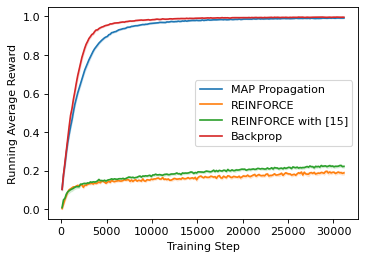

In [72]:
curves = {}
curves.update(np.load("graph/mp.npy", allow_pickle=True).item())  
#names = {"a5": "MAP Propagation", "c2": "REINFORCE", "e0": "REINFORCE with [15]", "b2": "Backprop"}  
#names = {"a5": "MAP Propagation", "c2": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop (Det.)", "f0": "Backprop (Sto.)"}  
names = {"a5": "MAP Propagation", "c2": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop"}  
plot(curves, names, mv_n=100, end_n=31250, xlabel="Training Step", ylabel="Running Average Reward", loc=5)
plt.savefig('fig1.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


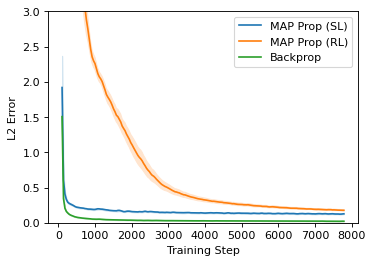

In [73]:
curves = {}
curves.update(np.load("graph/sr.npy", allow_pickle=True).item())  
for k, i in curves.items():  curves[k] = (curves[k][0],)
#names =  {"b5":"MAP Prop (SL)", "e5": "MAP Prop (RL)", "c2": "Backprop"} #"d1": "Backprop (RL)"
#names =  {"b5":"MAP Prop (SL)", "e5": "MAP Prop (RL)", "g0": "Backprop (Det.)", "f0": "Backprop (Sto.)"}
names =  {"b5":"MAP Prop (SL)", "e5": "MAP Prop (RL)", "g0": "Backprop"}
plot(curves, names, mv_n=100, end_n=31250//4, xlabel="Training Step", ylabel="L2 Error", ylim=[0,3], loc=1)
plt.savefig('fig2.eps', format='eps')

Stat on t_f (first eps. having perfect score) and t_s (eps. required to solve):
Stat on a3:
t_f: 10 / 10 achieved.
t_f: avg. 17.80 median 15.50 min 2.00 max 42.00 std 11.97
t_f:  [20  6 24 10  9 34 42 14  2 17]
t_s: 10 / 10 achieved.
t_s: avg. 116.80 median 110.00 min 100.00 max 157.00 std 20.93
t_s:  [116 100 156 100 100 157 119 100 111 109]
R: avg. -100.29 median -99.33 min -109.81 max -92.54 std 5.40
Stat on asy11:
t_f: 10 / 10 achieved.
t_f: avg. 21.70 median 4.50 min 2.00 max 89.00 std 29.31
t_f:  [22 18  5  4 67 89  3  2  4  3]
t_s: 9 / 10 achieved.
t_s: avg. 114.67 median 100.00 min 100.00 max 228.00 std 40.09
t_s:  [104 100 100 100 228  -1 100 100 100 100]
R: avg. -106.71 median -102.99 min -149.79 max -89.56 std 17.43
Stat on c10:
t_f: 10 / 10 achieved.
t_f: avg. 357.90 median 65.00 min 16.00 max 1748.00 std 611.66
t_f:  [  22   90   25   91 1390   16   40 1748  117   40]
t_s: 8 / 10 achieved.
t_s: avg. 164.00 median 160.50 min 117.00 max 221.00 std 37.73
t_s:  [139 182 120 18

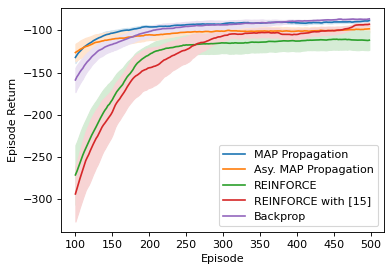

In [5]:
curves = {}
curves.update(np.load("graph/ab.npy", allow_pickle=True).item())   
env_name = "Acrobot-v1"
#"g4": "MAP Propagation", "asy11": "Asy. MAP Propagation"
#names = {"a3":"MAP Propagation", "c10": "REINFORCE", "e0": "REINFORCE with [15]", "bd3": "Backprop", }  
#names = {"a3":"MAP Prop", "c10": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop (Det.)", "f0": "Backprop (Sto.)"}  
names = {"a3":"MAP Propagation", "asy11": "Asy. MAP Propagation", "c10": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop"}  
#names = {"a3":"MAP Propagation", "c10": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop"}  
plot(curves, names, mv_n=100, end_n=500, size=1)
#plt.savefig('fig3.eps', format='eps')
print_stat(curves, names, env_name, end_n=500)

Stat on t_f (first eps. having perfect score) and t_s (eps. required to solve):
Stat on a2:
t_f: 10 / 10 achieved.
t_f: avg. 64.90 median 51.50 min 22.00 max 120.00 std 31.57
t_f:  [120  54  38  22  79  49  47  40  86 114]
t_s: 10 / 10 achieved.
t_s: avg. 271.50 median 245.50 min 188.00 max 451.00 std 76.57
t_s:  [302 209 209 188 358 229 278 247 451 244]
R: avg. 459.70 median 463.79 min 437.47 max 481.08 std 13.89
Stat on as1-3:
t_f: 10 / 10 achieved.
t_f: avg. 122.30 median 115.00 min 79.00 max 177.00 std 31.74
t_f:  [ 79 145 108 107 122 177  86 140 165  94]
t_s: 9 / 10 achieved.
t_s: avg. 397.11 median 336.00 min 271.00 max 887.00 std 176.80
t_s:  [271 396 887 336 375 329 333 295 352  -1]
R: avg. 418.61 median 426.67 min 356.00 max 459.56 std 29.15
Stat on c9:
t_f: 10 / 10 achieved.
t_f: avg. 1334.40 median 1282.50 min 1049.00 max 1791.00 std 234.38
t_f:  [1049 1357 1620 1791 1175 1476 1451 1208 1098 1119]
t_s: 0 / 10 achieved.
t_s:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
R: avg. 47.29 medi

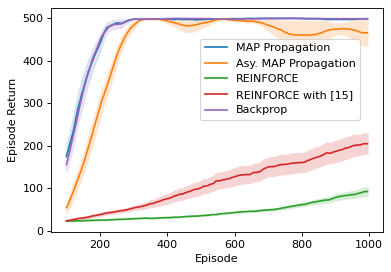

In [7]:
curves = {}
curves.update(np.load("graph/cp.npy", allow_pickle=True).item())  
env_name = "CartPole-v1"
#names = {"a2": "MAP Propagation", "c10": "REINFORCE", "e0": "REINFORCE with [15]", "baseline_cp": "Backprop", } #, "as1-3": "Asy. MAP Propagation" 
#names = {"a2": "MAP Propagation", "c9": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop (Det.)", "f0": "Backprop (Sto.)"} #, "as1-3": "Asy. MAP Propagation" 
#names = {"a2": "MAP Propagation", "c9": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop"} #, "as1-3": "Asy. MAP Propagation" 
names = {"a2": "MAP Propagation", "as1-3": "Asy. MAP Propagation", "c9": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop"}
plot(curves, names, mv_n=100, end_n=1000, loc=(0.45,0.5))
#plt.savefig('fig4.eps', format='eps')
print_stat(curves, names, env_name, end_n=1000)

Stat on t_f (first eps. having perfect score) and t_s (eps. required to solve):
Stat on a4:
t_f: 10 / 10 achieved.
t_f: avg. 425.60 median 411.50 min 257.00 max 628.00 std 121.99
t_f:  [423 257 427 576 390 628 400 567 283 305]
t_s: 8 / 10 achieved.
t_s: avg. 1418.00 median 1274.50 min 940.00 max 2107.00 std 382.66
t_s:  [1265 2107 1015 1878 1277   -1 1272   -1 1590  940]
R: avg. 127.88 median 133.77 min 66.36 max 153.66 std 24.57
Stat on n9:
t_f: 10 / 10 achieved.
t_f: avg. 693.50 median 664.00 min 365.00 max 1155.00 std 231.08
t_f:  [ 516  944  829  716  365  486 1155  502  612  810]
t_s: 3 / 10 achieved.
t_s: avg. 1235.33 median 1082.00 min 928.00 max 1696.00 std 331.75
t_s:  [  -1   -1   -1 1082   -1 1696   -1  928   -1   -1]
R: avg. 76.84 median 73.77 min 55.60 max 107.68 std 15.90
Stat on c2:
t_f: 10 / 10 achieved.
t_f: avg. 1520.90 median 1441.50 min 1262.00 max 1942.00 std 225.45
t_f:  [1513 1262 1679 1703 1328 1311 1774 1942 1370 1327]
t_s: 0 / 10 achieved.
t_s:  [-1 -1 -1 -1 -

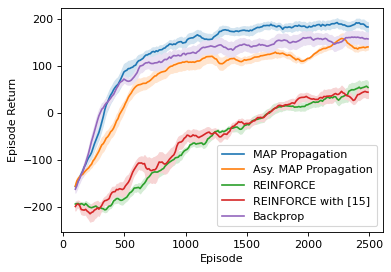

In [8]:
curves = {}
curves.update(np.load("graph/ll.npy", allow_pickle=True).item())  
env_name = "LunarLander-v2"
#names = {"m5-2": "MAP Propagation", "n9": "Asy. MAP Propagation", "p4": "Backprop"}  
#names = {"a4":"MAP Propagation","c2": "REINFORCE",  "e0": "REINFORCE with [15]", "p4": "Backprop", }  
#names = {"a4":"MAP Propagation","c2": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop (Det.)", "f0": "Backprop (Sto.)"}
#names = {"a4":"MAP Propagation","c2": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop"}
names = {"a4":"MAP Propagation", "n9": "Asy. MAP Propagation", "c2": "REINFORCE",  "e0": "REINFORCE with [15]",  "g0": "Backprop"}
plot(curves, names, mv_n=100, end_n=2500)
#plt.savefig('fig5.eps', format='eps')
print_stat(curves, names, env_name, end_n=2500)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Stat on t_f (first eps. having perfect score) and t_s (eps. required to solve):
Stat on t2:
t_f: 10 / 10 achieved.
t_f: avg. 220.10 median 212.00 min 123.00 max 404.00 std 74.92
t_f:  [201 265 179 254 151 233 223 123 404 168]
t_s: 0 / 10 achieved.
t_s:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
R: avg. 39.45 median 51.01 min -21.68 max 69.37 std 30.48
Stat on u3:
t_f: 9 / 10 achieved.
t_f: avg. 330.11 median 334.00 min 196.00 max 466.00 std 89.65
t_f:  [430 266 218  -1 334 287 466 196 408 366]
t_s: 0 / 10 achieved.
t_s:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
R: avg. 46.24 median 50.13 min 14.05 max 65.64 std 13.77
Stat on c14:
t_f: 0 / 10 achieved.
t_f:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
t_s: 0 / 10 achieved.
t_s:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
R: avg. -35.52 median -35.53 min -36.42 max -34.50 std 0.65
Stat on e0:
t_f: 0 / 10 achieved.
t_f:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
t_s: 0 / 10 achieved.
t_s:  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
R: avg. -4.65 median -4.57 min -5.13 max -4.32 std 0.21
Stat on g1:
t

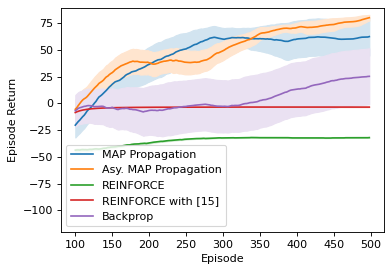

In [9]:
curves = {}
curves.update(np.load("graph/mc.npy", allow_pickle=True).item())   
env_name = "MountainCarContinuous-v0"
#names = {"t1-4": "MAP Propagation", "u3": "Asy. MAP Propagation", "r1": "Backprop"}  
#names = {"t1-4": "MAP Propagation", "c15": "REINFORCE", "e0": "REINFORCE with [15]", "r1": "Backprop", }  
#names = {"t2": "MAP Propagation", "c14": "REINFORCE", "e0": "REINFORCE with [15]",  "g1": "Backprop (Det.)", "f0": "Backprop (Sto.)"}  
#names = {"t2": "MAP Propagation", "c14": "REINFORCE", "e0": "REINFORCE with [15]",  "g1": "Backprop"}  
names = {"t2": "MAP Propagation", "u3": "Asy. MAP Propagation", "c14": "REINFORCE", "e0": "REINFORCE with [15]",  "g1": "Backprop"}  
plot(curves, names, mv_n=100, end_n=500, loc=3, ylim=-120)
plt.savefig('fig6.eps', format='eps')
print_stat(curves, names, env_name, end_n=500)

In [ ]:
curves = {}
curves.update(np.load("graph/cp.npy", allow_pickle=True).item())  
curves['baseline_cp'] = curves_['baseline_cp']
curves['as1-3'] = curves_['as1-3']
np.save("graph/cp.npy", curves)

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

c = [(curves['t1-4'][0][0], "MAP Propagation"),
     (curves['r1'][0][7], "Backprop - Successful"),
     (curves['r1'][0][0], "Backprop - Failed")
     ,]

plt.figure(figsize=(5, 3.5), dpi=80)
for i in c:      
  v = np.array(mv(i[0], 100))
  v = np.concatenate([np.full(99, np.nan),v])
  ax = plt.gca()         
  ax.plot(np.arange(500), v, label=i[1])
plt.xlabel('Episodes')
plt.ylabel('Running Average Rewards')   
plt.gca().legend(loc=4)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


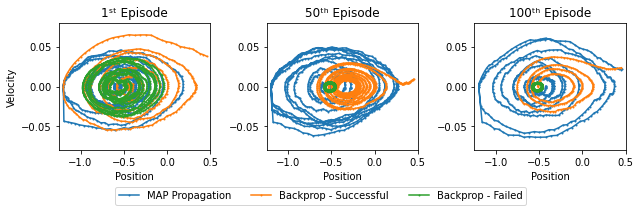

In [21]:
traj = {}
traj.update(np.load("graph/mc_traj.npy", allow_pickle=True).item())  

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15*0.6, 5.5*0.6))

ins = [[['map',0,'MAP Propagation'],['bp0',0,'Backprop - Successful'],['bp1',0,'Backprop - Failed'],],
       [['map',49,'MAP Propagation'],['bp0',49,'Backprop - Successful'],['bp1',49,'Backprop - Failed'],],
       [['map',99,'MAP Propagation'],['bp0',99,'Backprop - Successful'],['bp1',99,'Backprop - Failed'],],
      ]
captions = ["1ˢᵗ Episode", "50ᵗʰ Episode", "100ᵗʰ Episode"]

for n, m in enumerate(ins):  
  for k in m:
    l = np.array(traj[k[0]][k[1]])
    x = np.arange(0, len(l), 1)
    axs[n].plot(l[x,0], l[x,1], '-o', label=k[2], markersize=1,)      
  axs[n].title.set_text(captions[n])
  axs[n].set_xlim(-1.25, +0.50)
  axs[n].set_ylim(-0.08, +0.08)
  axs[n].set_xlabel('Position')
axs[0].set_ylabel('Velocity')  


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor = (0,0.1,1,1),
           bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.subplots_adjust(bottom=0.35)
plt.savefig('fig9.eps', format='eps')

In [130]:
len(traj['map'][0])

999